<a href="https://colab.research.google.com/github/ozguozkan/DI725_Assignment_1/blob/main/TransformerHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GITHUB ACCESS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm

In [5]:
!git clone https://github.com/caglarmert/DI725.git

Cloning into 'DI725'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 274 (delta 73), reused 86 (delta 34), pack-reused 101 (from 1)
Receiving objects: 100% (274/274), 4.43 MiB | 7.81 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [6]:
!pip install plotly

In [7]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA


In [8]:
os.chdir("/content/DI725/assignment_1") #getting into the cloned project
!pwd #cheching where are we

/content/DI725/assignment_1


In [9]:
!ls data/customer_service #the dataset folder

test.csv  train.csv


**Loading the data and EDA**

In [10]:
import pandas as pd
train_dataFrame = pd.read_csv("data/customer_service/train.csv")
test_dataFrame = pd.read_csv("data/customer_service/test.csv")

print("train",train_dataFrame.head())
print("test" ,test_dataFrame.head())


train                   issue_area                        issue_category  \
0          Login and Account  Mobile Number and Email Verification   
1  Cancellations and returns                   Pickup and Shipping   
2  Cancellations and returns        Replacement and Return Process   
3          Login and Account       Login Issues and Error Messages   
4                      Order                 Order Delivery Issues   

                                  issue_sub_category  \
0  Verification requirement for mobile number or ...   
1           Reasons for being asked to ship the item   
2             Inability to click the 'Cancel' button   
3  Error message regarding exceeded attempts to e...   
4                       Delivery not attempted again   

                         issue_category_sub_category customer_sentiment  \
0  Mobile Number and Email Verification -> Verifi...            neutral   
1  Pickup and Shipping -> Reasons for being asked...            neutral   
2  Replacem

In [11]:
#checking the columns and datatypes
print("Train data", train_dataFrame.info())
print("\nTest data", test_dataFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   issue_area                   970 non-null    object
 1   issue_category               970 non-null    object
 2   issue_sub_category           970 non-null    object
 3   issue_category_sub_category  970 non-null    object
 4   customer_sentiment           970 non-null    object
 5   product_category             970 non-null    object
 6   product_sub_category         970 non-null    object
 7   issue_complexity             970 non-null    object
 8   agent_experience_level       970 non-null    object
 9   agent_experience_level_desc  970 non-null    object
 10  conversation                 970 non-null    object
dtypes: object(11)
memory usage: 83.5+ KB
Train data None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 col

In [12]:
#seeing the columns
print("train columns", train_dataFrame.columns)
print("test columns", test_dataFrame.columns)

train columns Index(['issue_area', 'issue_category', 'issue_sub_category',
       'issue_category_sub_category', 'customer_sentiment', 'product_category',
       'product_sub_category', 'issue_complexity', 'agent_experience_level',
       'agent_experience_level_desc', 'conversation'],
      dtype='object')
test columns Index(['issue_area', 'issue_category', 'issue_sub_category',
       'issue_category_sub_category', 'customer_sentiment', 'product_category',
       'product_sub_category', 'issue_complexity', 'agent_experience_level',
       'agent_experience_level_desc', 'conversation'],
      dtype='object')


making everythink lowercase just in case a problem occurs

In [13]:
# converting to lowercase
train_dataFrame["customer_sentiment"] = train_dataFrame["customer_sentiment"].str.lower()

# display unique sentiment labels
print(train_dataFrame["customer_sentiment"].unique())

['neutral' 'negative' 'positive']


In [14]:
import plotly.express as px

# Sentiment
sentiment_counts = train_dataFrame["customer_sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["Sentiment Class", "Count"]  # column names

fig = px.bar(sentiment_counts, x="Sentiment Class", y="Count",
             labels={"Sentiment Class": "Sentiment Class", "Count": "Freq"},
             title="Customer Sentiment Distribution",
             color="Count",
             color_continuous_scale="purples")
fig.update_layout(
    plot_bgcolor="black",
    paper_bgcolor="black",
    font=dict(color="white")
)
#making the backgorund black because positive class is white so on the white bg we cant see it
fig.show()

In [ ]:
#from the above histogram we can see there is a class imbalance
#lets check whether there is null or not
print("missing values for train: ", train_dataFrame.isnull().sum())
print("missing values for test: ", test_dataFrame.isnull().sum())

missing values for train:  issue_area                     0
issue_category                 0
issue_sub_category             0
issue_category_sub_category    0
customer_sentiment             0
product_category               0
product_sub_category           0
issue_complexity               0
agent_experience_level         0
agent_experience_level_desc    0
conversation                   0
dtype: int64
missing values for test:  issue_area                     0
issue_category                 0
issue_sub_category             0
issue_category_sub_category    0
customer_sentiment             0
product_category               0
product_sub_category           0
issue_complexity               0
agent_experience_level         0
agent_experience_level_desc    0
conversation                   0
dtype: int64


In [ ]:
# message lengths
train_dataFrame["conversation_length"] = train_dataFrame["conversation"].apply(lambda x: len(str(x).split()))

# drawing the histogram
fig = px.histogram(train_dataFrame, x="conversation_length",
                   title="Distribution of Customer Message Lengths",
                   labels={"conversation_length": "Word Count"},
                   nbins=30, color_discrete_sequence=["purple"])


fig.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


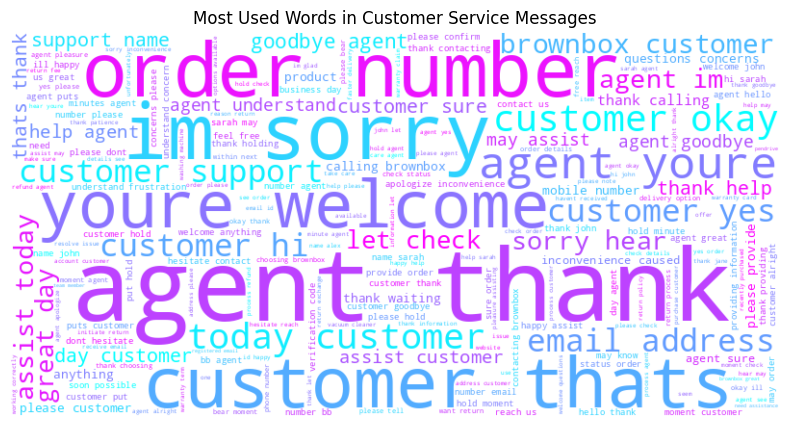

In [ ]:
#most used words with wordcloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

#stopwords with NLTK
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

#clearing the stopwords
def clean_msg(msg):
    msg = re.sub(r'[^a-zA-Z\s]', '', msg)  # clearing special chars
    msg = re.sub(r'http\S+', '', msg)  # clearing links
    msg = msg.lower()  # lowercase
    words = msg.split()
    words = [word for word in words if word not in stop_words]  # clearing stopwords
    return " ".join(words)

train_dataFrame["cleaned_text"] = train_dataFrame["conversation"].apply(clean_msg)

# combining messages
ful_words = " ".join(msg for msg in train_dataFrame["cleaned_text"])

# WordCloud visualization
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="cool").generate(ful_words)

# WordCloud'u çizelim
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Used Words in Customer Service Messages")
plt.show()

In [ ]:
#seeing whether the sentiments has a relation with message length
fig = px.box(train_dataFrame, x="customer_sentiment", y="conversation_length",
             title="Message Length",
             labels={"customer_sentiment": "Sentiment Class", "conversation_length": "Word Count"},
             color="customer_sentiment",
             color_discrete_sequence=px.colors.qualitative.Set1)

fig.show()

Horizontal Bar Chart for customer problem categories

In [ ]:
import plotly.express as px

# Count occurrences of each issue category
issue_counts = train_dataFrame["issue_category"].value_counts().reset_index()
issue_counts.columns = ["Support Issue Category", "Frequency"]  # Rename columns properly
#rename because a problem occurs without renameing

# bar chart
fig = px.bar(issue_counts, y="Support Issue Category", x="Frequency",
             labels={"Support Issue Category": "Issue Category", "Frequency": "Count"},
             title="Customer Support Issues Distribution",
             orientation="h",
             color="Frequency",
             color_continuous_scale="Blues")

# Set black background because in Bues colormap the whites doesnt shown
fig.update_layout(
    plot_bgcolor="black",
    paper_bgcolor="black",
    font=dict(color="white")
)

fig.show()


Most common words that used wih a bar chart

In [ ]:
# combining the messages
all_words = " ".join(text for text in train_dataFrame["conversation"])
word_counts = Counter(all_words.split())

# getting the most used 20
common_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])

fig = px.bar(common_words, x="Frequency", y="Word",
             title="Most Frequently Used Words in Customer Messages",
             color="Frequency",
             color_continuous_scale="Magma",
             orientation="h")

fig.show()


Bigram analysis for seeingthe  most used 2-word phrases

In [ ]:
# Creatin the 2 word bigrams
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
X = vectorizer.fit_transform(train_dataFrame["cleaned_text"])

# Get top bigrams
bigram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False).head(15)

fig = px.bar(bigram_counts.reset_index(), x=0, y="index",
             title="Most Frequent 2-Word Phrases (Bigrams)",
             labels={"index": "Bigram", 0: "Frequency"},
             color=0,
             color_continuous_scale="Inferno",
             orientation="h")

fig.show()


Correlation

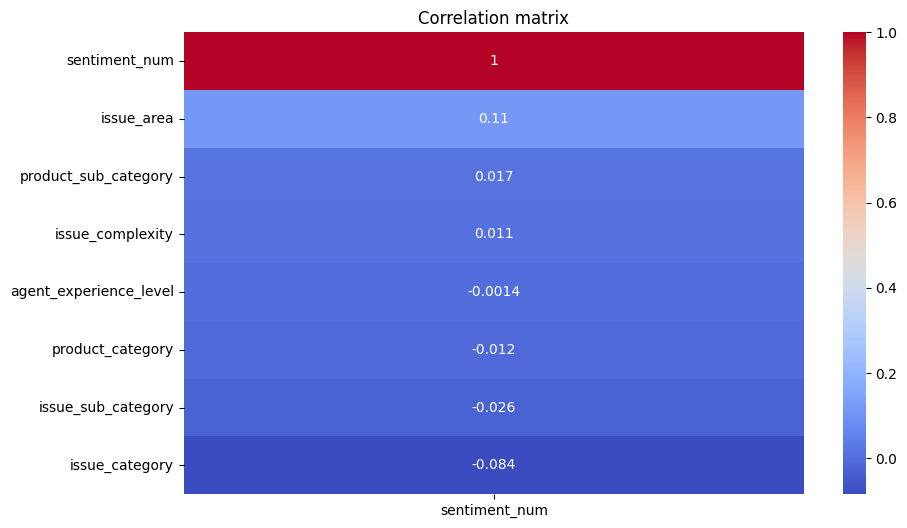

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# tranforming sentiments to numbers for making them categoric
df_corr = train_dataFrame.copy()
df_corr['sentiment_num'] = df_corr['customer_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# what columns i want to experiment
cat_cols = ['issue_area', 'issue_category', 'issue_sub_category', 'product_category',
            'product_sub_category', 'issue_complexity', 'agent_experience_level']
for col in cat_cols:
    df_corr[col] = df_corr[col].astype('category').cat.codes

# correlation matrix and visualisation
corr_matrix = df_corr[cat_cols + ['sentiment_num']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['sentiment_num']].sort_values(by='sentiment_num', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()


WANDB CONFIG

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ozgukan to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

PREPROCESS

In [15]:
!pip install pandas scikit-learn

In [16]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# cleaning the text for spaces and punctuations
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

train_dataFrame = pd.read_csv("data/customer_service/train.csv")
test_dataFrame = pd.read_csv("data/customer_service/test.csv")

df = train_dataFrame[['conversation', 'customer_sentiment']].copy() #getting the neccessary
df.columns = ['text', 'label']

# making labels numeratic
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_map)

df['text'] = df['text'].apply(clean_text) #cleaning the text

# train val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# save
pd.DataFrame({'text': train_texts, 'label': train_labels}).to_csv("data/customer_service/processed_train.csv", index=False)
pd.DataFrame({'text': val_texts, 'label': val_labels}).to_csv("data/customer_service/processed_val.csv", index=False)

# same for test
# test_dataFrame = pd.read_csv("test.csv")
test_clean = test_dataFrame[['conversation']].copy()
test_clean.columns = ['text']
test_clean['text'] = test_clean['text'].apply(clean_text)

# saving the test
test_clean.to_csv("data/customer_service/processed_test.csv", index=False)


checking if everything is ok

In [17]:
# load
df_train = pd.read_csv("data/customer_service/processed_train.csv")
df_val = pd.read_csv("data/customer_service/processed_val.csv")

# seeing the first rows
print("Train examples:")
print(df_train.head())

print("\nValidation examples:")
print(df_val.head())


Train examples:
                                                text  label
0  customer hi im calling because i have an issue...      0
1  customer hi i received an email from brownbox ...      1
2  agent thank you for contacting brownbox custom...      1
3  agent thank you for calling brownbox customer ...      1
4  agent hello thank you for contacting brownbox ...      1

Validation examples:
                                                text  label
0  agent hello thank you for calling brownbox cus...      1
1  agent thank you for calling brownbox customer ...      1
2  agent thank you for calling brownbox customer ...      1
3  agent hello thank you for contacting brownbox ...      0
4  agent thank you for calling brownbox customer ...      0


In [ ]:
print("train label distribution:")
print(df_train['label'].value_counts())

print("\nVal label dsit.:")
print(df_val['label'].value_counts())


train label distribution:
label
1    434
0    329
2     13
Name: count, dtype: int64

Val label dsit.:
label
1    108
0     82
2      4
Name: count, dtype: int64


In [ ]:
print("ex cleaned text:")
print(df_train['text'].iloc[0])


ex cleaned text:
customer hi im calling because i have an issue with my recent order i purchased an air cooler from brownbox but i havent received the refund in my bank account yet agent hi im sorry to hear that i can definitely help you with that may i please have your order number so i can look into this issue for you customer sure its bb123456789 agent thank you for that im sorry to hear that you havent received your refund yet could you please confirm the date when you returned the air cooler customer i returned it on august 1st 2021 agent thank you for that information i can see that the refund was processed on august 5th 2021 and it should have been credited to your bank account within 57 business days can you please confirm the bank account details you provided for the refund customer yes the bank account details i provided were correct agent i apologize for the inconvenience caused sometimes it may take a little longer for the refund to reflect in your account due to certain ba

In [18]:
# See if the test set is cleaned correctly
df_test = pd.read_csv("data/customer_service/processed_test.csv")
print("Test example:")
print(df_test['text'].iloc[0])

Test example:
agent thank you for calling brownbox customer support my name is sarah how may i assist you today customer hi sarah i am calling because i am interested in buying a hand blender but the price seems too high i heard that you offer discounts through exchange offers can you help me with that agent of course i can help you with that may i know which hand blender you are interested in and do you have an old blender that you would like to exchange customer yes i am interested in the xyz hand blender and i do have an old blender that i would like to exchange agent great let me check if we have any ongoing exchange offers for the xyz hand blender please hold on for a moment agent puts the customer on hold to check the ongoing offers agent thank you for your patience i have good news for you we do have an ongoing exchange offer for the xyz hand blender if you exchange your old blender you can get a discount of 20 on the xyz hand blender customer that sounds great how do i avail of

In [19]:
print(df_test.head())

                                                text
0  agent thank you for calling brownbox customer ...
1  agent thank you for calling brownbox customer ...
2  agent thank you for calling brownbox customer ...
3  agent thank you for calling brownbox customer ...
4  agent thank you for calling brownbox customer ...
